In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re

In [3]:
api = wandb.Api(timeout=19)

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [112]:
bright_factor = 0.75
best_n_runs = 10
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 1,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_homeostasis_I_only"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 0, "config.use_sep_bias_gain_lrs": 0, "config.lambda_homeo": 1,
                                                                    "config.homeostatic_annealing": None }, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_homeostasis_I_frozen"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 0, "config.use_sep_bias_gain_lrs": 0, 
                                                                    "config.lambda_homeo": 0,  "config.homeostatic_annealing": 0 }, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_homeostasis_I_frozen_LN"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 1,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 0, "config.use_sep_bias_gain_lrs": 0, 
                                                                    "config.lambda_homeo": 0, "config.homeostatic_annealing": 0 }, order="-summary_metrics.test_acc")[:best_n_runs]
runs_dict["runs_homeostasis_EI"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                    "config.homeostatic_annealing": 0 }, order="-summary_metrics.test_acc")[:best_n_runs]

dict_keys(['runs_vanilla_dann', 'runs_vanilla_dann_layernorm', 'runs_homeostasis_I_only', 'runs_homeostasis_I_frozen', 'runs_homeostasis_I_frozen_LN', 'runs_homeostasis_EI'])


Text(0.5, 1.0, 'Brightness Factor 0.75')

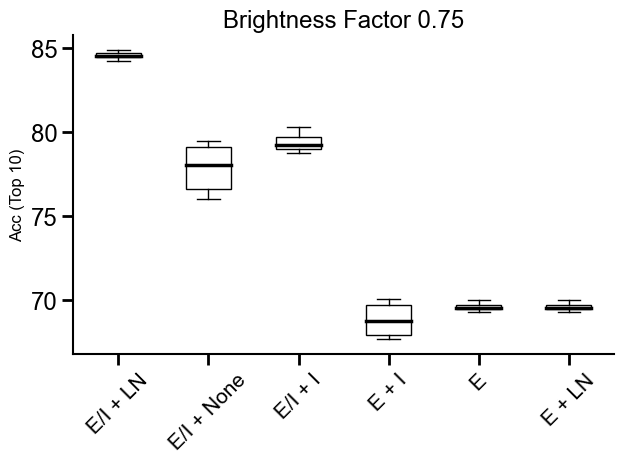

In [113]:
fig, ax = plt.subplots()

print(runs_dict.keys())
elements = []

keys = ["runs_vanilla_dann_layernorm", "runs_vanilla_dann", "runs_homeostasis_EI", "runs_homeostasis_I_only", "runs_homeostasis_I_frozen", "runs_homeostasis_I_frozen_LN"]

acc = []
for key in keys:
    temp_acc = []
    for idx, run in enumerate(runs_dict[key]):
        temp_acc.append(run.summary['test_acc'])

    acc.append(temp_acc)

ax.boxplot(np.array(acc).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                        showfliers=False)

    #elements.append(bp)
# Create custom x-axis tick labels
label_keys = ["E/I + LN", "E/I + None", "E/I + I", "E + I", "E", "E + LN"]
custom_xticks = [el for el in label_keys]
ax.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax.set_xticklabels(custom_xticks, fontsize=15,  rotation=45)

ax.set_ylabel('Acc (Top 10)')
ax.set_title(f'Brightness Factor {bright_factor}')

#ax.legend([el["medians"][0] for el in elements], keys, fontsize="10", loc ="best")
#ax.legend([bp3["medians"][0]], ['H'], loc='lower left')
#ax.set_yscale('log')